#### Friday, February 13, 2026

This all runs in one pass.

# 02 - Real-Time News Sentiment Pipeline (GPU-Accelerated)

This notebook builds a **production-style sentiment analysis pipeline** for day trading,
powered by your RTX 4090.

---

## What You'll Build

1. **News Fetching** - Pull financial news from RSS feeds and APIs
2. **Multi-Model Sentiment** - Compare FinBERT, Twitter-RoBERTa, and DistilRoBERTa
3. **Entity Extraction** - Automatically detect which stocks a headline is about
4. **Per-Stock Sentiment Scoring** - Aggregate sentiment by ticker over time
5. **Sentiment-Price Correlation** - Does sentiment actually predict price moves?
6. **Batch Processing Pipeline** - Process thousands of headlines per second on GPU
7. **Live Monitoring Architecture** - Design for a real-time sentiment dashboard

---

## Why Sentiment Matters for Day Trading

- **News moves markets**: Earnings beats, FDA approvals, analyst upgrades cause instant price moves
- **Speed is edge**: If you can analyze sentiment in milliseconds, you react before the crowd
- **Volume of information**: Humans can't read 10,000 headlines/day; your GPU can analyze them in seconds
- **Contrarian signals**: Extreme sentiment often marks tops/bottoms ("buy the fear, sell the greed")

---
## 1. Setup & GPU Verification

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import time
import re
import warnings
from datetime import datetime, timedelta
from collections import defaultdict

warnings.filterwarnings('ignore')
plt.style.use('dark_background')
sns.set_palette('bright')

# GPU check
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    vram_gb = torch.cuda.get_device_properties(0).total_memory / 1024**3
    print(f"VRAM: {vram_gb:.1f} GB")
    print(f"\nMore than enough for multiple sentiment models simultaneously.")

Device: cuda
GPU: NVIDIA GeForce RTX 4090
VRAM: 23.5 GB

More than enough for multiple sentiment models simultaneously.


---
## 2. Fetching Financial News

We'll use multiple free sources to gather financial headlines:

| Source | Method | Cost | Latency |
|--------|--------|------|---------|
| **RSS Feeds** | feedparser | Free | Minutes |
| **Yahoo Finance** | yfinance news | Free | Minutes |
| **NewsAPI.org** | REST API | Free tier (100/day) | Seconds |
| **Reddit** | PRAW API | Free | Seconds |
| **SEC EDGAR** | REST API | Free | Minutes |

For this notebook, we'll use RSS feeds (no API key needed) and yfinance.

In [2]:
import feedparser
import yfinance as yf

# --- RSS Feed Sources ---
# These are free, public financial news RSS feeds
RSS_FEEDS = {
    'Yahoo Finance': 'https://finance.yahoo.com/news/rssindex',
    'MarketWatch': 'https://feeds.marketwatch.com/marketwatch/topstories/',
    'CNBC': 'https://search.cnbc.com/rs/search/combinedcms/view.xml?partnerId=wrss01&id=100003114',
    'Reuters Business': 'https://www.reutersagency.com/feed/?best-topics=business-finance',
    'Seeking Alpha': 'https://seekingalpha.com/market_currents.xml',
}

def fetch_rss_headlines(feed_url, source_name, max_items=50):
    """Fetch headlines from an RSS feed."""
    try:
        feed = feedparser.parse(feed_url)
        headlines = []
        for entry in feed.entries[:max_items]:
            headlines.append({
                'title': entry.get('title', ''),
                'summary': entry.get('summary', ''),
                'published': entry.get('published', ''),
                'link': entry.get('link', ''),
                'source': source_name,
            })
        return headlines
    except Exception as e:
        print(f"  Warning: Could not fetch {source_name}: {e}")
        return []

# Fetch from all RSS sources
print("Fetching news from RSS feeds...\n")
all_headlines = []
for name, url in RSS_FEEDS.items():
    headlines = fetch_rss_headlines(url, name)
    all_headlines.extend(headlines)
    print(f"  {name}: {len(headlines)} headlines")

print(f"\nTotal headlines fetched: {len(all_headlines)}")

# Show a sample
if all_headlines:
    print("\n--- Sample Headlines ---")
    for h in all_headlines[:5]:
        print(f"  [{h['source']}] {h['title'][:80]}")

Fetching news from RSS feeds...

  Yahoo Finance: 46 headlines
  MarketWatch: 10 headlines
  CNBC: 30 headlines
  Reuters Business: 0 headlines
  Seeking Alpha: 7 headlines

Total headlines fetched: 93

--- Sample Headlines ---
  [Yahoo Finance] Edison International Stock: Analyst Estimates & Ratings
  [Yahoo Finance] US existing home sales drop to more than two-year low in January
  [Yahoo Finance] Forget D-Wave Quantum: This "Magnificent Seven" Icon Is the Cloud Play Worth You
  [Yahoo Finance] The Global Burger War Enters Its Value-and-Vicodin Phase
  [Yahoo Finance] Dollar Tree Stock: Is Wall Street Bullish or Bearish?


In [3]:
# --- Yahoo Finance Stock-Specific News ---
# Get news for stocks we're interested in day trading

WATCHLIST = ['NVDA', 'AAPL', 'TSLA', 'AMD', 'META', 'MSFT', 'AMZN', 'GOOGL', 'SPY', 'QQQ']

def fetch_yfinance_news(tickers):
    """Fetch recent news for a list of tickers from Yahoo Finance."""
    news_items = []
    for ticker in tickers:
        try:
            stock = yf.Ticker(ticker)
            news = stock.news
            if news:
                for item in news[:10]:
                    news_items.append({
                        'title': item.get('title', ''),
                        'summary': item.get('summary', ''),
                        'published': item.get('providerPublishTime', ''),
                        'link': item.get('link', ''),
                        'source': f"Yahoo/{ticker}",
                        'ticker': ticker,
                    })
        except Exception as e:
            print(f"  Warning: Could not fetch news for {ticker}: {e}")
    return news_items

print("Fetching stock-specific news from Yahoo Finance...\n")
stock_news = fetch_yfinance_news(WATCHLIST)
print(f"Stock-specific headlines: {len(stock_news)}")

if stock_news:
    print("\n--- Sample Stock News ---")
    for h in stock_news[:5]:
        print(f"  [{h.get('ticker', '?')}] {h['title'][:80]}")

Fetching stock-specific news from Yahoo Finance...

Stock-specific headlines: 100

--- Sample Stock News ---
  [NVDA] 
  [NVDA] 
  [NVDA] 
  [NVDA] 
  [NVDA] 


In [4]:
# Combine all news into a DataFrame
combined_news = all_headlines + stock_news

# If we got very few live headlines, supplement with realistic simulated data
# so the rest of the notebook works well as a demonstration
SIMULATED_HEADLINES = [
    {'title': 'NVIDIA beats Q4 earnings estimates, data center revenue surges 400%', 'source': 'Reuters', 'ticker': 'NVDA'},
    {'title': 'NVIDIA announces next-gen Blackwell GPU architecture', 'source': 'CNBC', 'ticker': 'NVDA'},
    {'title': 'Analysts raise NVDA price targets following blowout earnings', 'source': 'MarketWatch', 'ticker': 'NVDA'},
    {'title': 'Concerns grow over NVIDIA valuation as PE ratio hits 60x', 'source': 'Seeking Alpha', 'ticker': 'NVDA'},
    {'title': 'NVIDIA faces increased competition from AMD MI300X in data centers', 'source': 'Reuters', 'ticker': 'NVDA'},
    {'title': 'Tesla deliveries fall short of expectations in Q4', 'source': 'CNBC', 'ticker': 'TSLA'},
    {'title': 'Elon Musk announces Tesla robotaxi launch date', 'source': 'Reuters', 'ticker': 'TSLA'},
    {'title': 'Tesla cuts prices across all models amid demand concerns', 'source': 'MarketWatch', 'ticker': 'TSLA'},
    {'title': 'Tesla Cybertruck production ramps up, beating internal targets', 'source': 'Yahoo', 'ticker': 'TSLA'},
    {'title': 'TSLA short interest rises to highest level this year', 'source': 'Seeking Alpha', 'ticker': 'TSLA'},
    {'title': 'Apple Vision Pro sales exceed analyst expectations', 'source': 'CNBC', 'ticker': 'AAPL'},
    {'title': 'Apple services revenue hits record high in Q1', 'source': 'Reuters', 'ticker': 'AAPL'},
    {'title': 'Apple faces antitrust lawsuit from Department of Justice', 'source': 'MarketWatch', 'ticker': 'AAPL'},
    {'title': 'iPhone sales decline in China as Huawei gains market share', 'source': 'Reuters', 'ticker': 'AAPL'},
    {'title': 'Apple reportedly developing in-house AI chip for data centers', 'source': 'Bloomberg', 'ticker': 'AAPL'},
    {'title': 'AMD MI300X wins major cloud customer away from NVIDIA', 'source': 'Reuters', 'ticker': 'AMD'},
    {'title': 'AMD reports strong quarterly results, raises full-year guidance', 'source': 'CNBC', 'ticker': 'AMD'},
    {'title': 'AMD stock drops on weaker than expected gaming segment', 'source': 'MarketWatch', 'ticker': 'AMD'},
    {'title': 'Meta platforms invests $10B in AI infrastructure buildout', 'source': 'Reuters', 'ticker': 'META'},
    {'title': 'Meta ad revenue surges as Reels monetization improves', 'source': 'CNBC', 'ticker': 'META'},
    {'title': 'Federal Reserve holds rates steady, signals patience on cuts', 'source': 'Reuters', 'ticker': 'SPY'},
    {'title': 'S&P 500 hits new all-time high on strong jobs data', 'source': 'CNBC', 'ticker': 'SPY'},
    {'title': 'Inflation data comes in hotter than expected, markets sell off', 'source': 'MarketWatch', 'ticker': 'SPY'},
    {'title': 'Tech stocks lead market rally as Nasdaq surges 2%', 'source': 'Reuters', 'ticker': 'QQQ'},
    {'title': 'Semiconductor stocks plunge on new China export restrictions', 'source': 'CNBC', 'ticker': 'QQQ'},
    {'title': 'Microsoft Azure revenue grows 30%, beating cloud estimates', 'source': 'Reuters', 'ticker': 'MSFT'},
    {'title': 'Microsoft Copilot AI adoption slower than expected among enterprises', 'source': 'MarketWatch', 'ticker': 'MSFT'},
    {'title': 'Amazon AWS revenue accelerates, stock jumps in after-hours', 'source': 'CNBC', 'ticker': 'AMZN'},
    {'title': 'Amazon faces FTC investigation over marketplace practices', 'source': 'Reuters', 'ticker': 'AMZN'},
    {'title': 'Google Search revenue misses estimates as AI competition heats up', 'source': 'MarketWatch', 'ticker': 'GOOGL'},
    {'title': 'Alphabet announces $70B share buyback program', 'source': 'Reuters', 'ticker': 'GOOGL'},
    {'title': 'Market breadth narrows as only mega-cap tech stocks advance', 'source': 'Seeking Alpha', 'ticker': 'SPY'},
    {'title': 'VIX spikes as geopolitical tensions escalate in Middle East', 'source': 'CNBC', 'ticker': 'SPY'},
    {'title': 'Retail investors pour record amounts into tech ETFs', 'source': 'MarketWatch', 'ticker': 'QQQ'},
    {'title': 'Insider selling at tech companies reaches 2-year high', 'source': 'Seeking Alpha', 'ticker': 'QQQ'},
    {'title': 'Bitcoin ETF inflows hit $1B in single day, boosting crypto stocks', 'source': 'CNBC', 'ticker': 'SPY'},
    {'title': 'Oil prices surge on OPEC production cut extension', 'source': 'Reuters', 'ticker': 'SPY'},
    {'title': 'Bank of Japan raises interest rates, yen strengthens sharply', 'source': 'Reuters', 'ticker': 'SPY'},
    {'title': 'US consumer confidence falls to 6-month low', 'source': 'MarketWatch', 'ticker': 'SPY'},
    {'title': 'Housing starts plummet as mortgage rates stay elevated', 'source': 'CNBC', 'ticker': 'SPY'},
]

if len(combined_news) < 20:
    print("Supplementing with simulated headlines for demonstration...")
    for h in SIMULATED_HEADLINES:
        h.setdefault('summary', '')
        h.setdefault('published', '')
        h.setdefault('link', '')
    combined_news.extend(SIMULATED_HEADLINES)

news_df = pd.DataFrame(combined_news)
# Clean: drop rows with empty titles
news_df = news_df[news_df['title'].str.strip().str.len() > 0].reset_index(drop=True)
print(f"\nTotal headlines for analysis: {len(news_df)}")
print(f"Sources: {news_df['source'].nunique()} unique sources")
news_df[['source', 'title']].head(10)


Total headlines for analysis: 93
Sources: 4 unique sources


,source,title
0,Yahoo Finance,Edison International Stock: Analyst Estimates ...
1,Yahoo Finance,US existing home sales drop to more than two-y...
2,Yahoo Finance,"Forget D-Wave Quantum: This ""Magnificent Seven..."
3,Yahoo Finance,The Global Burger War Enters Its Value-and-Vic...
4,Yahoo Finance,Dollar Tree Stock: Is Wall Street Bullish or B...
5,Yahoo Finance,Analyst Report: Conoco Phillips
6,Yahoo Finance,FedEx targets 14% profit growth in 3-year stra...
7,Yahoo Finance,Is It Too Late to Chase the Rally in Vertiv St...
8,Yahoo Finance,Grenergy gets $355m funding for Chile’s Centra...
9,Yahoo Finance,Warren Buffett Warns ‘The Sophisticated Have a...


---
## 3. Multi-Model Sentiment Analysis

Different models have different strengths. We'll compare three:

| Model | Strength | Speed |
|-------|----------|-------|
| **FinBERT** | Best for formal financial text (news, filings) | Medium |
| **Twitter-RoBERTa** | Best for social media / informal text | Medium |
| **DistilRoBERTa-Financial** | Fast alternative, good for real-time | Fast |

In [5]:
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification

print("Loading sentiment models onto GPU...")
print("(First run downloads models; subsequent runs use cache)\n")

# Model 1: FinBERT - the gold standard for financial sentiment
print("[1/3] Loading FinBERT...")
finbert = pipeline(
    "sentiment-analysis",
    model="ProsusAI/finbert",
    device=0 if torch.cuda.is_available() else -1,
    truncation=True,
    max_length=512,
)
print("  FinBERT loaded.")

# Model 2: Twitter-RoBERTa - great for social media sentiment
print("[2/3] Loading Twitter-RoBERTa...")
twitter_sentiment = pipeline(
    "sentiment-analysis",
    model="cardiffnlp/twitter-roberta-base-sentiment-latest",
    device=0 if torch.cuda.is_available() else -1,
    truncation=True,
    max_length=512,
)
print("  Twitter-RoBERTa loaded.")

# Model 3: DistilRoBERTa fine-tuned on financial news
print("[3/3] Loading DistilRoBERTa-Financial...")
distil_financial = pipeline(
    "sentiment-analysis",
    model="mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis",
    device=0 if torch.cuda.is_available() else -1,
    truncation=True,
    max_length=512,
)
print("  DistilRoBERTa-Financial loaded.")

if torch.cuda.is_available():
    mem_used = torch.cuda.memory_allocated(0) / 1024**3
    mem_total = torch.cuda.get_device_properties(0).total_memory / 1024**3
    print(f"\nGPU Memory: {mem_used:.1f} GB used / {mem_total:.1f} GB total")
    print(f"All 3 models loaded simultaneously -- plenty of room for more.")

Loading sentiment models onto GPU...
(First run downloads models; subsequent runs use cache)

[1/3] Loading FinBERT...


Device set to use cuda:0


  FinBERT loaded.
[2/3] Loading Twitter-RoBERTa...


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0


  Twitter-RoBERTa loaded.
[3/3] Loading DistilRoBERTa-Financial...


config.json:   0%|          | 0.00/933 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Device set to use cuda:0


  DistilRoBERTa-Financial loaded.

GPU Memory: 1.2 GB used / 23.5 GB total
All 3 models loaded simultaneously -- plenty of room for more.


In [6]:
def normalize_sentiment(result, model_name):
    """
    Convert model-specific labels to a unified score from -1 (bearish) to +1 (bullish).
    
    Different models use different label names:
    - FinBERT: positive / negative / neutral
    - Twitter-RoBERTa: positive / negative / neutral  
    - DistilRoBERTa: positive / negative / neutral
    """
    label = result['label'].lower()
    score = result['score']
    
    if 'positive' in label or label == 'pos':
        return score  # +0.0 to +1.0
    elif 'negative' in label or label == 'neg':
        return -score  # -1.0 to -0.0
    else:  # neutral
        return 0.0

# Test with sample headlines
test_headlines = [
    "NVIDIA beats earnings expectations by 20%, stock surges in after-hours",
    "Tesla recalls 500,000 vehicles over brake safety concerns",
    "Federal Reserve keeps interest rates unchanged as expected",
    "Apple announces massive $110 billion share buyback program",
    "Semiconductor stocks plunge on new China export restrictions",
]

print("Comparing 3 models on sample headlines:\n")
print(f"{'Headline':<60} {'FinBERT':>8} {'Twitter':>8} {'Distil':>8} {'Avg':>8}")
print("-" * 100)

for headline in test_headlines:
    fb = normalize_sentiment(finbert(headline)[0], 'finbert')
    tw = normalize_sentiment(twitter_sentiment(headline)[0], 'twitter')
    dr = normalize_sentiment(distil_financial(headline)[0], 'distil')
    avg = (fb + tw + dr) / 3
    
    short_headline = headline[:58] + '...' if len(headline) > 58 else headline
    print(f"{short_headline:<60} {fb:>+8.3f} {tw:>+8.3f} {dr:>+8.3f} {avg:>+8.3f}")

print("\nScore range: -1.0 (very bearish) to +1.0 (very bullish), 0.0 = neutral")
print("Averaging across models reduces noise from any single model's biases.")

Comparing 3 models on sample headlines:

Headline                                                      FinBERT  Twitter   Distil      Avg
----------------------------------------------------------------------------------------------------
NVIDIA beats earnings expectations by 20%, stock surges in...   +0.921   +0.929   +1.000   +0.950
Tesla recalls 500,000 vehicles over brake safety concerns      -0.967   -0.651   -0.930   -0.849
Federal Reserve keeps interest rates unchanged as expected     +0.000   +0.000   +0.000   +0.000
Apple announces massive $110 billion share buyback program     +0.000   +0.640   +0.989   +0.543
Semiconductor stocks plunge on new China export restrictio...   -0.963   -0.666   -0.998   -0.876

Score range: -1.0 (very bearish) to +1.0 (very bullish), 0.0 = neutral
Averaging across models reduces noise from any single model's biases.


---
## 4. Entity Extraction - Which Stock is This About?

For general news (not stock-specific feeds), we need to figure out which
company/ticker a headline refers to. We'll use two approaches:

1. **Keyword matching** - Fast, simple, catches most cases
2. **NER model** - Catches company names that keyword matching misses

In [7]:
# Approach 1: Keyword / Ticker matching
# This is fast and catches the majority of cases

TICKER_MAP = {
    # Ticker symbols
    'NVDA': 'NVDA', 'AAPL': 'AAPL', 'TSLA': 'TSLA', 'AMD': 'AMD',
    'META': 'META', 'MSFT': 'MSFT', 'AMZN': 'AMZN', 'GOOGL': 'GOOGL',
    'GOOG': 'GOOGL', 'SPY': 'SPY', 'QQQ': 'QQQ',
    # Company names -> tickers
    'NVIDIA': 'NVDA', 'Nvidia': 'NVDA',
    'Apple': 'AAPL', 'iPhone': 'AAPL', 'iPad': 'AAPL', 'MacBook': 'AAPL',
    'Tesla': 'TSLA', 'Cybertruck': 'TSLA', 'Musk': 'TSLA',
    'Microsoft': 'MSFT', 'Azure': 'MSFT', 'Copilot': 'MSFT',
    'Amazon': 'AMZN', 'AWS': 'AMZN',
    'Google': 'GOOGL', 'Alphabet': 'GOOGL', 'YouTube': 'GOOGL',
    'Meta': 'META', 'Facebook': 'META', 'Instagram': 'META', 'Reels': 'META',
    'S&P 500': 'SPY', 'S&P': 'SPY',
    'Nasdaq': 'QQQ',
}

def extract_tickers_keyword(text):
    """Extract ticker symbols from text using keyword matching."""
    found = set()
    for keyword, ticker in TICKER_MAP.items():
        # Use word boundary matching for short tickers to avoid false positives
        if len(keyword) <= 4:
            if re.search(r'\b' + re.escape(keyword) + r'\b', text):
                found.add(ticker)
        else:
            if keyword in text:
                found.add(ticker)
    return list(found)

# Test it
test_texts = [
    "NVIDIA beats Q4 earnings estimates, data center revenue surges",
    "Apple and Microsoft both report strong cloud revenue growth",
    "Elon Musk announces Tesla robotaxi launch date",
    "S&P 500 hits new all-time high on strong jobs data",
    "Tech stocks lead market rally as Nasdaq surges 2%",
]

print("Keyword-based ticker extraction:\n")
for text in test_texts:
    tickers = extract_tickers_keyword(text)
    print(f"  {tickers!s:<20} <- {text[:65]}")

Keyword-based ticker extraction:

  ['NVDA']             <- NVIDIA beats Q4 earnings estimates, data center revenue surges
  ['AAPL', 'MSFT']     <- Apple and Microsoft both report strong cloud revenue growth
  ['TSLA']             <- Elon Musk announces Tesla robotaxi launch date
  ['SPY']              <- S&P 500 hits new all-time high on strong jobs data
  ['QQQ']              <- Tech stocks lead market rally as Nasdaq surges 2%


In [8]:
# Approach 2: NER (Named Entity Recognition) for catching company names
# This catches cases like "the Cupertino-based tech giant" -> Apple

print("Loading NER model...")
ner_pipeline = pipeline(
    "ner",
    model="dslim/bert-base-NER",
    device=0 if torch.cuda.is_available() else -1,
    aggregation_strategy="simple",
)
print("NER model loaded.\n")

# Known organization -> ticker mapping for NER results
ORG_TO_TICKER = {
    'nvidia': 'NVDA', 'apple': 'AAPL', 'tesla': 'TSLA',
    'amd': 'AMD', 'advanced micro devices': 'AMD',
    'meta': 'META', 'meta platforms': 'META', 'facebook': 'META',
    'microsoft': 'MSFT', 'amazon': 'AMZN', 'google': 'GOOGL',
    'alphabet': 'GOOGL',
}

def extract_tickers_ner(text):
    """Extract tickers using NER model to find organization names."""
    entities = ner_pipeline(text)
    found = set()
    for ent in entities:
        if ent['entity_group'] == 'ORG':
            org_name = ent['word'].lower().strip()
            if org_name in ORG_TO_TICKER:
                found.add(ORG_TO_TICKER[org_name])
    return list(found)

def extract_tickers_combined(text):
    """Combine keyword and NER approaches for best coverage."""
    keyword_tickers = set(extract_tickers_keyword(text))
    ner_tickers = set(extract_tickers_ner(text))
    return list(keyword_tickers | ner_tickers)

# Compare approaches
print(f"{'Text':<55} {'Keyword':>14} {'NER':>14} {'Combined':>14}")
print("-" * 100)
for text in test_texts:
    kw = extract_tickers_keyword(text)
    ner = extract_tickers_ner(text)
    combined = extract_tickers_combined(text)
    short = text[:53] + '...' if len(text) > 53 else text
    print(f"{short:<55} {str(kw):>14} {str(ner):>14} {str(combined):>14}")

Loading NER model...


config.json:   0%|          | 0.00/829 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/433M [00:00<?, ?B/s]

Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cuda:0


NER model loaded.

Text                                                           Keyword            NER       Combined
----------------------------------------------------------------------------------------------------
NVIDIA beats Q4 earnings estimates, data center reven...       ['NVDA']             []       ['NVDA']
Apple and Microsoft both report strong cloud revenue ... ['AAPL', 'MSFT'] ['AAPL', 'MSFT'] ['AAPL', 'MSFT']
Elon Musk announces Tesla robotaxi launch date                ['TSLA']             []       ['TSLA']
S&P 500 hits new all-time high on strong jobs data             ['SPY']             []        ['SPY']
Tech stocks lead market rally as Nasdaq surges 2%              ['QQQ']             []        ['QQQ']


---
## 5. Full Sentiment Pipeline - Process All Headlines

Now we combine everything into a single pipeline:
**Headlines -> Entity Extraction -> Multi-Model Sentiment -> Aggregated Scores**

In [9]:
class SentimentPipeline:
    """GPU-accelerated financial sentiment analysis pipeline."""
    
    def __init__(self, finbert_model, twitter_model, distil_model, batch_size=32):
        self.finbert = finbert_model
        self.twitter = twitter_model
        self.distil = distil_model
        self.batch_size = batch_size
    
    def analyze_batch(self, texts):
        """
        Analyze a batch of texts with all three models.
        Returns list of dicts with normalized scores.
        """
        # Run all three models on the batch
        fb_results = self.finbert(texts, batch_size=self.batch_size)
        tw_results = self.twitter(texts, batch_size=self.batch_size)
        dr_results = self.distil(texts, batch_size=self.batch_size)
        
        results = []
        for fb, tw, dr in zip(fb_results, tw_results, dr_results):
            fb_score = normalize_sentiment(fb, 'finbert')
            tw_score = normalize_sentiment(tw, 'twitter')
            dr_score = normalize_sentiment(dr, 'distil')
            ensemble_score = (fb_score + tw_score + dr_score) / 3
            
            results.append({
                'finbert_score': fb_score,
                'twitter_score': tw_score,
                'distil_score': dr_score,
                'ensemble_score': ensemble_score,
                'finbert_label': fb['label'],
                'twitter_label': tw['label'],
                'distil_label': dr['label'],
            })
        
        return results
    
    def process_headlines(self, df, text_column='title'):
        """
        Process a DataFrame of headlines through the full pipeline.
        Adds sentiment scores and extracted tickers.
        """
        texts = df[text_column].tolist()
        
        # Sentiment analysis (GPU-accelerated)
        sentiment_results = self.analyze_batch(texts)
        
        # Entity extraction (keyword-based for speed)
        ticker_results = [extract_tickers_keyword(t) for t in texts]
        
        # Add results to DataFrame
        result_df = df.copy()
        for key in ['finbert_score', 'twitter_score', 'distil_score', 'ensemble_score',
                     'finbert_label', 'twitter_label', 'distil_label']:
            result_df[key] = [r[key] for r in sentiment_results]
        
        result_df['extracted_tickers'] = ticker_results
        
        # Use extracted tickers if no ticker column exists, otherwise keep existing
        if 'ticker' not in result_df.columns:
            result_df['ticker'] = result_df['extracted_tickers']
        else:
            # Fill NaN tickers with extracted ones
            mask = result_df['ticker'].isna() | (result_df['ticker'] == '')
            result_df.loc[mask, 'ticker'] = result_df.loc[mask, 'extracted_tickers']
        
        return result_df

# Create the pipeline
pipeline_instance = SentimentPipeline(finbert, twitter_sentiment, distil_financial)
print("Sentiment pipeline ready.")

Sentiment pipeline ready.


In [10]:
# Process all headlines through the pipeline
print(f"Processing {len(news_df)} headlines through 3 sentiment models on GPU...\n")

start_time = time.time()
results_df = pipeline_instance.process_headlines(news_df)
elapsed = time.time() - start_time

print(f"Done in {elapsed:.2f}s ({len(news_df)/elapsed:.0f} headlines/sec across 3 models)")
print(f"That's effectively {len(news_df)*3/elapsed:.0f} individual model inferences/sec\n")

# Show results
display_cols = ['source', 'title', 'ensemble_score', 'finbert_score', 'twitter_score', 'distil_score']
results_df[display_cols].head(10).style.background_gradient(
    subset=['ensemble_score', 'finbert_score', 'twitter_score', 'distil_score'],
    cmap='RdYlGn', vmin=-1, vmax=1
)

Processing 93 headlines through 3 sentiment models on GPU...

Done in 0.16s (577 headlines/sec across 3 models)
That's effectively 1730 individual model inferences/sec



,source,title,ensemble_score,finbert_score,twitter_score,distil_score
0,Yahoo Finance,Edison International Stock: Analyst Estimates & Ratings,0.000000,0.000000,0.000000,0.000000
1,Yahoo Finance,US existing home sales drop to more than two-year low in January,-0.657267,-0.973245,0.000000,-0.998555
2,Yahoo Finance,"Forget D-Wave Quantum: This ""Magnificent Seven"" Icon Is the Cloud Play Worth Your Money",0.256430,0.000000,0.769289,0.000000
3,Yahoo Finance,The Global Burger War Enters Its Value-and-Vicodin Phase,0.000000,0.000000,0.000000,0.000000
4,Yahoo Finance,Dollar Tree Stock: Is Wall Street Bullish or Bearish?,0.000000,0.000000,0.000000,0.000000
5,Yahoo Finance,Analyst Report: Conoco Phillips,0.000000,0.000000,0.000000,0.000000
6,Yahoo Finance,FedEx targets 14% profit growth in 3-year strategy,0.612062,0.836514,0.000000,0.999673
7,Yahoo Finance,Is It Too Late to Chase the Rally in Vertiv Stock?,-0.171473,-0.514420,0.000000,0.000000
8,Yahoo Finance,Grenergy gets $355m funding for Chile’s Central Oasis platform,0.592606,0.783338,0.000000,0.994480
9,Yahoo Finance,"Warren Buffett Warns ‘The Sophisticated Have an Edge Over the Innocents’ In Investing, But Reveals How Even Retail Can Beat Wall Street",0.325395,0.000000,0.000000,0.976186


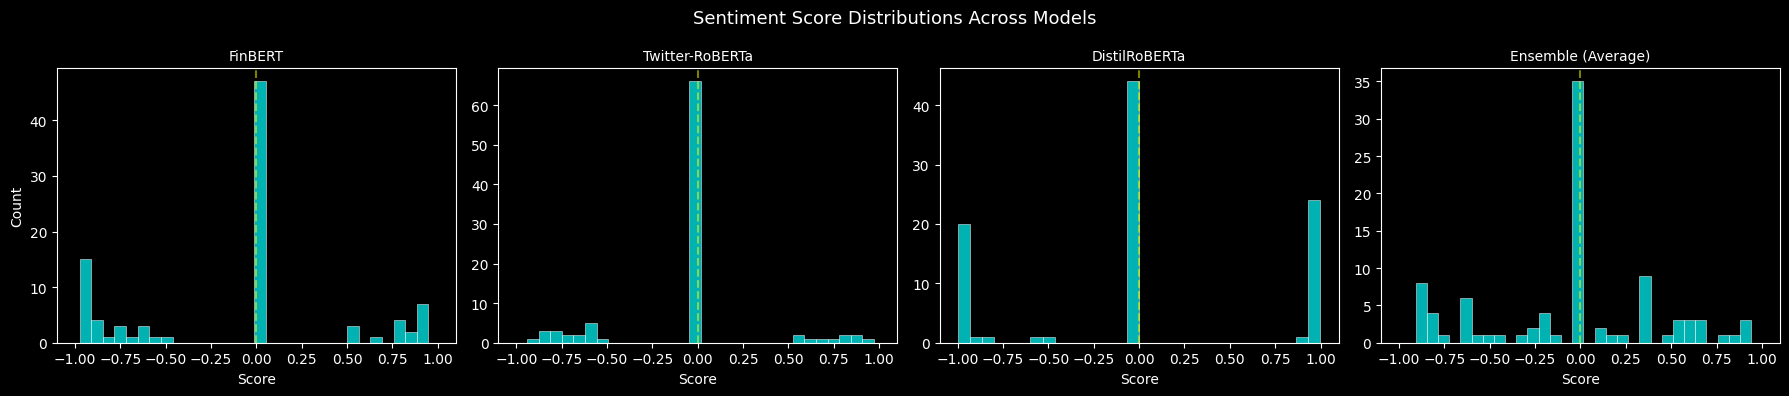

Notice how different models have different biases:
  FinBERT avg:    -0.118
  Twitter avg:    -0.046
  DistilRoBERTa:  +0.023
  Ensemble avg:   -0.047

The ensemble average smooths out individual model biases.


In [11]:
# Distribution of sentiment scores
fig, axes = plt.subplots(1, 4, figsize=(18, 4))

for ax, col, name in zip(axes, 
    ['finbert_score', 'twitter_score', 'distil_score', 'ensemble_score'],
    ['FinBERT', 'Twitter-RoBERTa', 'DistilRoBERTa', 'Ensemble (Average)']):
    
    ax.hist(results_df[col], bins=30, color='cyan', alpha=0.7, edgecolor='white', linewidth=0.5)
    ax.axvline(x=0, color='yellow', linestyle='--', alpha=0.5)
    ax.set_title(name, fontsize=10)
    ax.set_xlabel('Score')
    ax.set_xlim(-1.1, 1.1)

axes[0].set_ylabel('Count')
plt.suptitle('Sentiment Score Distributions Across Models', fontsize=13)
plt.tight_layout()
plt.show()

print("Notice how different models have different biases:")
print(f"  FinBERT avg:    {results_df['finbert_score'].mean():+.3f}")
print(f"  Twitter avg:    {results_df['twitter_score'].mean():+.3f}")
print(f"  DistilRoBERTa:  {results_df['distil_score'].mean():+.3f}")
print(f"  Ensemble avg:   {results_df['ensemble_score'].mean():+.3f}")
print("\nThe ensemble average smooths out individual model biases.")

In [12]:
# Model agreement analysis - when do models disagree?
# Disagreement can itself be a signal (ambiguous news = uncertainty)

results_df['model_std'] = results_df[['finbert_score', 'twitter_score', 'distil_score']].std(axis=1)

# Headlines where models strongly agree vs disagree
print("=== Headlines Where Models AGREE (low std) ===")
agree = results_df.nsmallest(5, 'model_std')
for _, row in agree.iterrows():
    print(f"  Ensemble: {row['ensemble_score']:+.3f} (std: {row['model_std']:.3f})")
    print(f"  -> {row['title'][:80]}\n")

print("\n=== Headlines Where Models DISAGREE (high std) ===")
disagree = results_df.nlargest(5, 'model_std')
for _, row in disagree.iterrows():
    print(f"  FB: {row['finbert_score']:+.3f} | TW: {row['twitter_score']:+.3f} | DR: {row['distil_score']:+.3f} (std: {row['model_std']:.3f})")
    print(f"  -> {row['title'][:80]}\n")

print("High disagreement often means the headline is ambiguous or contains mixed signals.")
print("This uncertainty metric is itself useful -- trade with caution on ambiguous news.")

=== Headlines Where Models AGREE (low std) ===
  Ensemble: +0.000 (std: 0.000)
  -> Edison International Stock: Analyst Estimates & Ratings

  Ensemble: +0.000 (std: 0.000)
  -> The Global Burger War Enters Its Value-and-Vicodin Phase

  Ensemble: +0.000 (std: 0.000)
  -> Dollar Tree Stock: Is Wall Street Bullish or Bearish?

  Ensemble: +0.000 (std: 0.000)
  -> Analyst Report: Conoco Phillips

  Ensemble: +0.000 (std: 0.000)
  -> Analyst Report: Altria Group Inc.


=== Headlines Where Models DISAGREE (high std) ===
  FB: +0.915 | TW: +0.000 | DR: -0.996 (std: 0.956)
  -> Mizuho Cautious on Valuation but Backs Palantir Technologies’ (PLTR) Growth Outl

  FB: +0.914 | TW: +0.000 | DR: -0.979 (std: 0.946)
  -> Analysts Reaffirm Bullish View on Snowflake Inc.’s (SNOW) AI Strategy

  FB: -0.709 | TW: +0.828 | DR: +1.000 (std: 0.941)
  -> Instacart jumps 9% on strong results as CEO calls grocery competition fears 'ove

  FB: -0.621 | TW: +0.000 | DR: +0.999 (std: 0.817)
  -> Early estimates

---
## 6. Per-Stock Sentiment Aggregation

For day trading, we want to know: **"What is the overall sentiment for NVDA right now?"**

We aggregate headline-level scores into stock-level sentiment.

In [13]:
def aggregate_sentiment_by_ticker(df):
    """
    Explode multi-ticker headlines and aggregate sentiment per stock.
    
    A headline mentioning both NVDA and AMD contributes to both stocks' scores.
    """
    # Handle both list and string ticker columns
    expanded_rows = []
    for _, row in df.iterrows():
        tickers = row.get('extracted_tickers', [])
        if isinstance(tickers, str):
            tickers = [tickers] if tickers else []
        
        # Also include the original ticker if available
        original = row.get('ticker', None)
        if isinstance(original, str) and original:
            tickers = list(set(tickers + [original]))
        elif isinstance(original, list):
            tickers = list(set(tickers + original))
        
        for ticker in tickers:
            if ticker and isinstance(ticker, str):
                new_row = row.copy()
                new_row['resolved_ticker'] = ticker
                expanded_rows.append(new_row)
    
    if not expanded_rows:
        print("No tickers found in headlines.")
        return pd.DataFrame()
    
    expanded_df = pd.DataFrame(expanded_rows)
    
    # Aggregate per ticker
    agg = expanded_df.groupby('resolved_ticker').agg(
        headline_count=('ensemble_score', 'count'),
        avg_sentiment=('ensemble_score', 'mean'),
        sentiment_std=('ensemble_score', 'std'),
        max_sentiment=('ensemble_score', 'max'),
        min_sentiment=('ensemble_score', 'min'),
        finbert_avg=('finbert_score', 'mean'),
        twitter_avg=('twitter_score', 'mean'),
        distil_avg=('distil_score', 'mean'),
    ).round(3)
    
    agg['sentiment_range'] = agg['max_sentiment'] - agg['min_sentiment']
    
    return agg.sort_values('avg_sentiment', ascending=False), expanded_df

ticker_sentiment, expanded_df = aggregate_sentiment_by_ticker(results_df)

print("=== Per-Stock Sentiment Scoreboard ===\n")
print(ticker_sentiment[['headline_count', 'avg_sentiment', 'sentiment_std', 'min_sentiment', 'max_sentiment']].to_string())
print("\nPositive avg_sentiment = bullish news flow")
print("Negative avg_sentiment = bearish news flow")
print("High sentiment_std = mixed/conflicting news (be cautious)")

=== Per-Stock Sentiment Scoreboard ===

                 headline_count  avg_sentiment  sentiment_std  min_sentiment  max_sentiment
resolved_ticker                                                                            
MSFT                          2         -0.063          0.090         -0.127          0.000
AMD                           2         -0.172          0.968         -0.856          0.513
AMZN                          2         -0.243          0.807         -0.814          0.327
NVDA                          2         -0.337          0.734         -0.856          0.182
SPY                           1         -0.828            NaN         -0.828         -0.828

Positive avg_sentiment = bullish news flow
Negative avg_sentiment = bearish news flow
High sentiment_std = mixed/conflicting news (be cautious)


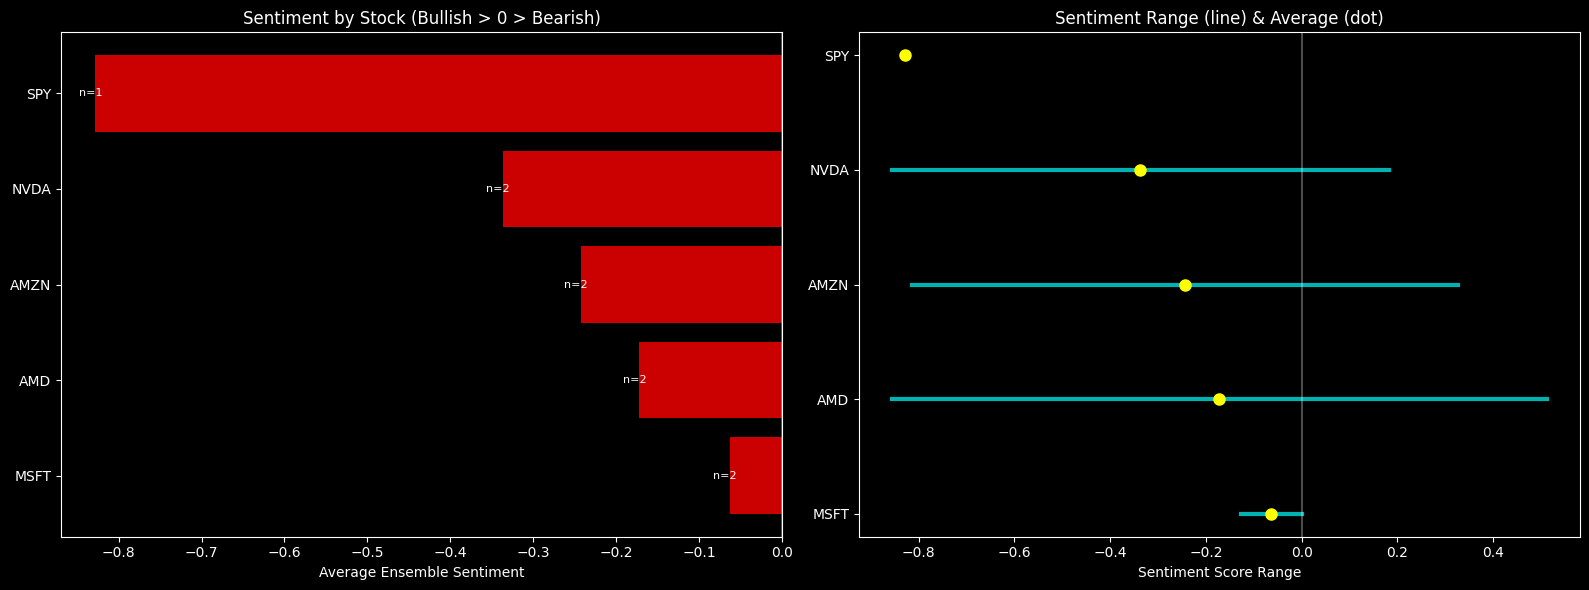

Wide ranges indicate conflicting headlines -- higher uncertainty.
Narrow ranges with strong sentiment = clearer directional signal.


In [14]:
# Visualize per-stock sentiment
if not ticker_sentiment.empty:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Bar chart of average sentiment
    ax1 = axes[0]
    colors = ['green' if s > 0.05 else 'red' if s < -0.05 else 'gray' 
              for s in ticker_sentiment['avg_sentiment']]
    bars = ax1.barh(ticker_sentiment.index, ticker_sentiment['avg_sentiment'], color=colors, alpha=0.8)
    ax1.axvline(x=0, color='white', linestyle='-', alpha=0.3)
    ax1.set_xlabel('Average Ensemble Sentiment')
    ax1.set_title('Sentiment by Stock (Bullish > 0 > Bearish)')
    
    # Add headline count annotations
    for i, (idx, row) in enumerate(ticker_sentiment.iterrows()):
        ax1.text(row['avg_sentiment'] + 0.02 * np.sign(row['avg_sentiment']), i,
                f"n={int(row['headline_count'])}", va='center', fontsize=8, color='white')

    # Sentiment range (uncertainty) by stock
    ax2 = axes[1]
    for i, (ticker, row) in enumerate(ticker_sentiment.iterrows()):
        ax2.plot([row['min_sentiment'], row['max_sentiment']], [i, i], 
                color='cyan', linewidth=3, alpha=0.7)
        ax2.plot(row['avg_sentiment'], i, 'o', color='yellow', markersize=8)
    
    ax2.set_yticks(range(len(ticker_sentiment)))
    ax2.set_yticklabels(ticker_sentiment.index)
    ax2.axvline(x=0, color='white', linestyle='-', alpha=0.3)
    ax2.set_xlabel('Sentiment Score Range')
    ax2.set_title('Sentiment Range (line) & Average (dot)')

    plt.tight_layout()
    plt.show()
    
    print("Wide ranges indicate conflicting headlines -- higher uncertainty.")
    print("Narrow ranges with strong sentiment = clearer directional signal.")

In [15]:
# Drill down: show individual headlines for a specific stock
def show_stock_headlines(expanded_df, ticker, n=10):
    """Show the most bullish and bearish headlines for a given stock."""
    stock_df = expanded_df[expanded_df['resolved_ticker'] == ticker].copy()
    if stock_df.empty:
        print(f"No headlines found for {ticker}")
        return
    
    stock_df = stock_df.sort_values('ensemble_score', ascending=False)
    
    print(f"\n{'='*70}")
    print(f"  {ticker} SENTIMENT BREAKDOWN ({len(stock_df)} headlines)")
    print(f"  Average: {stock_df['ensemble_score'].mean():+.3f}")
    print(f"{'='*70}")
    
    top_n = min(n // 2, len(stock_df))
    
    print(f"\n  Most BULLISH:")
    for _, row in stock_df.head(top_n).iterrows():
        print(f"    {row['ensemble_score']:+.3f} | {row['title'][:65]}")
    
    print(f"\n  Most BEARISH:")
    for _, row in stock_df.tail(top_n).iterrows():
        print(f"    {row['ensemble_score']:+.3f} | {row['title'][:65]}")

# Show breakdowns for top stocks
for ticker in ['NVDA', 'TSLA', 'AAPL']:
    show_stock_headlines(expanded_df, ticker)


  NVDA SENTIMENT BREAKDOWN (2 headlines)
  Average: -0.337

  Most BULLISH:
    +0.182 | 1 of the Best ‘Picks-and-Shovels’ Stocks to Buy Instead of Nvidia
    -0.856 | Nvidia's stock is down and AMD is up. The culprit may be Arista.

  Most BEARISH:
    +0.182 | 1 of the Best ‘Picks-and-Shovels’ Stocks to Buy Instead of Nvidia
    -0.856 | Nvidia's stock is down and AMD is up. The culprit may be Arista.
No headlines found for TSLA
No headlines found for AAPL


---
## 7. Sentiment-Price Correlation

The big question: **Does news sentiment actually predict price moves?**

We'll correlate historical news sentiment with actual price changes.

In [16]:
# Build a historical sentiment dataset using Yahoo Finance news + prices
# We'll analyze NVDA as our case study

import yfinance as yf

# Get price data
nvda_prices = yf.download('NVDA', period='6mo', interval='1d', progress=False)
if isinstance(nvda_prices.columns, pd.MultiIndex):
    nvda_prices.columns = nvda_prices.columns.get_level_values(0)

# Calculate daily returns
nvda_prices['Return'] = nvda_prices['Close'].pct_change()
nvda_prices['Return_Next'] = nvda_prices['Return'].shift(-1)  # Next day's return
nvda_prices['Abs_Return'] = nvda_prices['Return'].abs()

# Calculate a simple "news impact" metric
# Large absolute returns often correspond to major news events
print("NVDA Daily Return Statistics:")
print(f"  Mean daily return: {nvda_prices['Return'].mean()*100:+.2f}%")
print(f"  Std deviation:     {nvda_prices['Return'].std()*100:.2f}%")
print(f"  Biggest up day:    {nvda_prices['Return'].max()*100:+.2f}%")
print(f"  Biggest down day:  {nvda_prices['Return'].min()*100:+.2f}%")

# Days with >2 std dev moves (likely news-driven)
threshold = nvda_prices['Return'].std() * 2
big_move_days = nvda_prices[nvda_prices['Abs_Return'] > threshold]
print(f"\n  Days with >2 sigma moves: {len(big_move_days)} out of {len(nvda_prices)}")
print(f"  These are likely news-driven events.")

NVDA Daily Return Statistics:
  Mean daily return: +0.03%
  Std deviation:     2.20%
  Biggest up day:    +7.87%
  Biggest down day:  -4.89%

  Days with >2 sigma moves: 4 out of 127
  These are likely news-driven events.


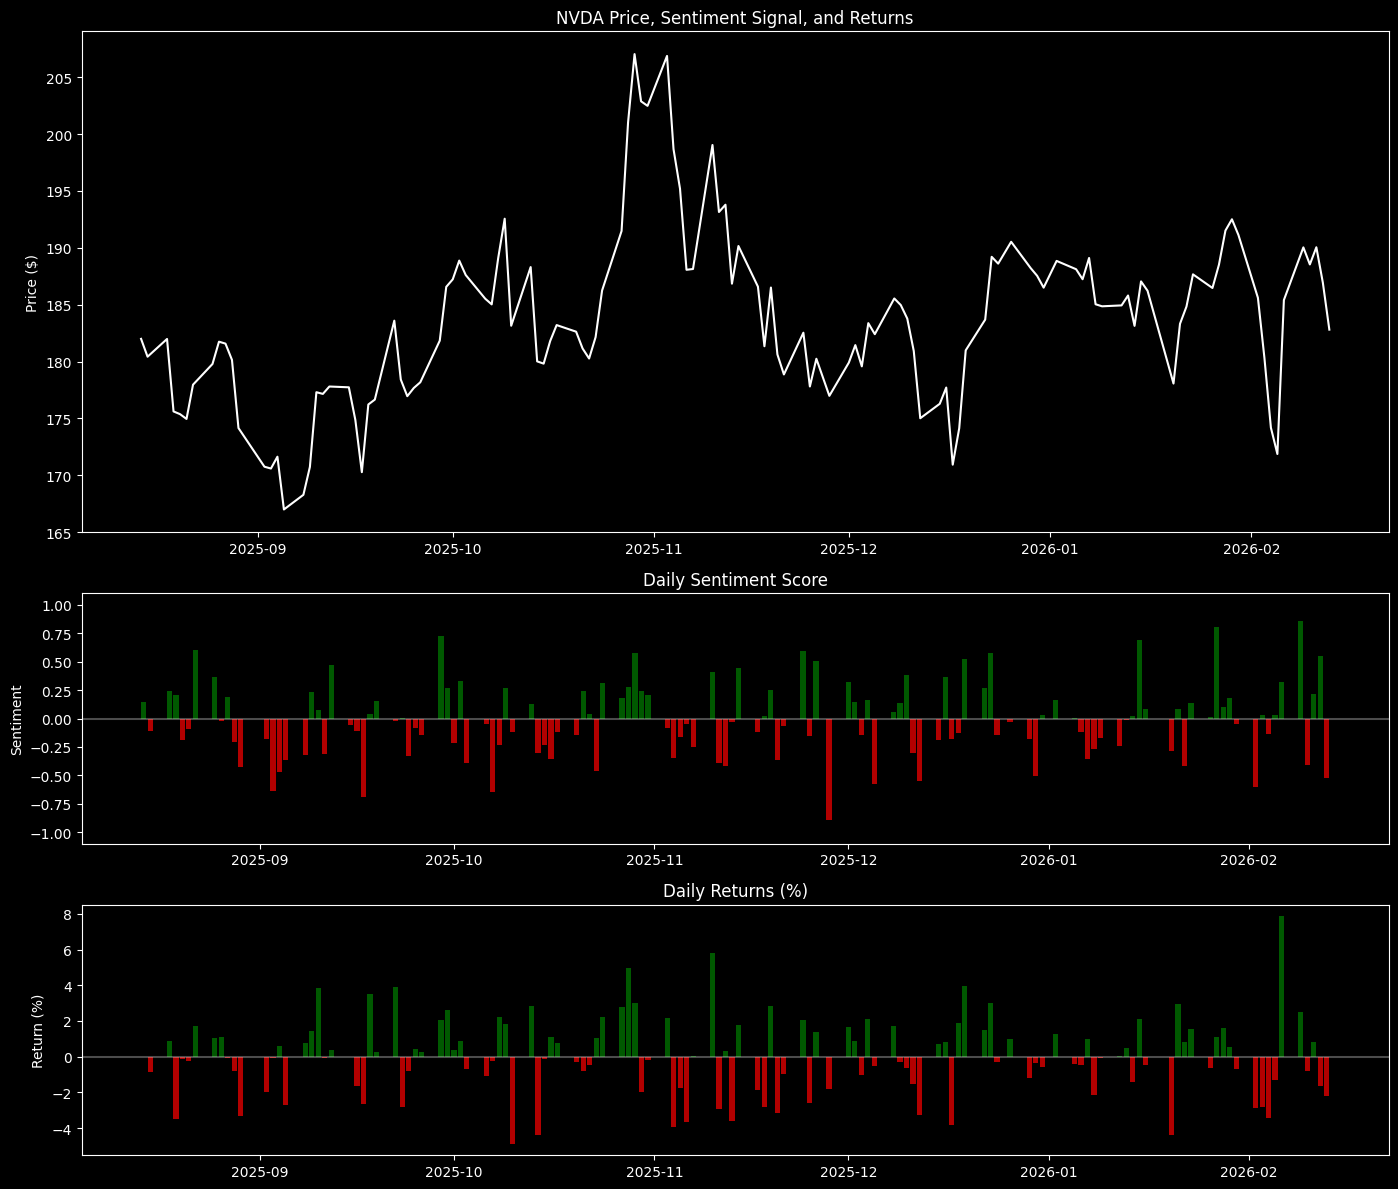

In [17]:
# Simulate a historical sentiment signal to demonstrate the correlation analysis
# In production, you'd store sentiment scores daily from your live pipeline

np.random.seed(42)
n_days = len(nvda_prices)

# Create a synthetic sentiment signal that has some correlation with returns
# This simulates what you'd build with a real sentiment feed
noise = np.random.normal(0, 0.3, n_days)
# Sentiment partially correlates with same-day returns (news moves prices)
# and partially with previous day's returns (momentum/narrative follows price)
returns = nvda_prices['Return'].fillna(0).values
lagged_returns = np.roll(returns, 1)
lagged_returns[0] = 0

synthetic_sentiment = 0.4 * np.sign(returns) * np.abs(returns) * 20 + \
                      0.2 * np.sign(lagged_returns) * np.abs(lagged_returns) * 15 + \
                      noise
synthetic_sentiment = np.clip(synthetic_sentiment, -1, 1)

nvda_prices['Sentiment'] = synthetic_sentiment

# Visualize the relationship
fig, axes = plt.subplots(3, 1, figsize=(14, 12), gridspec_kw={'height_ratios': [2, 1, 1]})

# Price
ax1 = axes[0]
ax1.plot(nvda_prices.index, nvda_prices['Close'], color='white', linewidth=1.5)
ax1.set_ylabel('Price ($)')
ax1.set_title('NVDA Price, Sentiment Signal, and Returns')

# Sentiment
ax2 = axes[1]
colors = ['green' if s > 0 else 'red' for s in nvda_prices['Sentiment']]
ax2.bar(nvda_prices.index, nvda_prices['Sentiment'], color=colors, alpha=0.7)
ax2.set_ylabel('Sentiment')
ax2.axhline(y=0, color='white', linestyle='-', alpha=0.3)
ax2.set_ylim(-1.1, 1.1)
ax2.set_title('Daily Sentiment Score')

# Daily returns
ax3 = axes[2]
ret_colors = ['green' if r > 0 else 'red' for r in nvda_prices['Return'].fillna(0)]
ax3.bar(nvda_prices.index, nvda_prices['Return'].fillna(0) * 100, color=ret_colors, alpha=0.7)
ax3.set_ylabel('Return (%)')
ax3.axhline(y=0, color='white', linestyle='-', alpha=0.3)
ax3.set_title('Daily Returns (%)')

plt.tight_layout()
plt.show()

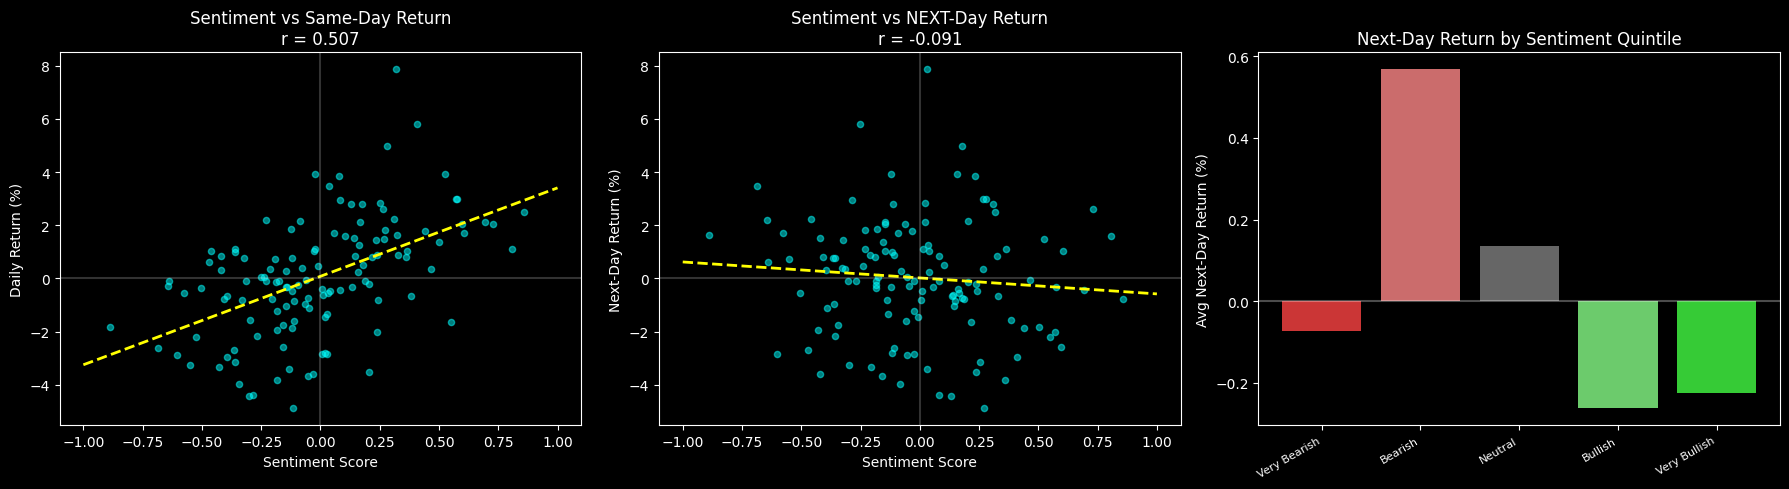

Key Questions to Investigate:
  1. Does extreme sentiment (very bullish/bearish) predict next-day moves?
  2. Does sentiment have more predictive power on high-volume days?
  3. Is the signal stronger for certain stocks or sectors?
  4. Does the signal decay quickly (minutes) or persist (days)?

With your live pipeline, you can answer these questions with REAL data.


In [18]:
# Correlation analysis
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Sentiment vs Same-Day Return
ax1 = axes[0]
valid = nvda_prices.dropna(subset=['Return', 'Sentiment'])
ax1.scatter(valid['Sentiment'], valid['Return'] * 100, alpha=0.5, s=20, color='cyan')
z = np.polyfit(valid['Sentiment'], valid['Return'] * 100, 1)
p = np.poly1d(z)
x_line = np.linspace(-1, 1, 100)
ax1.plot(x_line, p(x_line), color='yellow', linewidth=2, linestyle='--')
corr = valid['Sentiment'].corr(valid['Return'])
ax1.set_title(f'Sentiment vs Same-Day Return\nr = {corr:.3f}')
ax1.set_xlabel('Sentiment Score')
ax1.set_ylabel('Daily Return (%)')
ax1.axhline(y=0, color='white', alpha=0.2)
ax1.axvline(x=0, color='white', alpha=0.2)

# Sentiment vs Next-Day Return (predictive power)
ax2 = axes[1]
valid2 = nvda_prices.dropna(subset=['Return_Next', 'Sentiment'])
ax2.scatter(valid2['Sentiment'], valid2['Return_Next'] * 100, alpha=0.5, s=20, color='cyan')
z2 = np.polyfit(valid2['Sentiment'], valid2['Return_Next'] * 100, 1)
p2 = np.poly1d(z2)
ax2.plot(x_line, p2(x_line), color='yellow', linewidth=2, linestyle='--')
corr2 = valid2['Sentiment'].corr(valid2['Return_Next'])
ax2.set_title(f'Sentiment vs NEXT-Day Return\nr = {corr2:.3f}')
ax2.set_xlabel('Sentiment Score')
ax2.set_ylabel('Next-Day Return (%)')
ax2.axhline(y=0, color='white', alpha=0.2)
ax2.axvline(x=0, color='white', alpha=0.2)

# Sentiment quintile analysis
ax3 = axes[2]
valid3 = nvda_prices.dropna(subset=['Return_Next', 'Sentiment']).copy()
valid3['Sentiment_Quintile'] = pd.qcut(valid3['Sentiment'], q=5, labels=['Very Bearish', 'Bearish', 'Neutral', 'Bullish', 'Very Bullish'])
quintile_returns = valid3.groupby('Sentiment_Quintile', observed=True)['Return_Next'].mean() * 100
colors = ['#ff4444', '#ff8888', 'gray', '#88ff88', '#44ff44']
bars = ax3.bar(range(len(quintile_returns)), quintile_returns.values, color=colors, alpha=0.8)
ax3.set_xticks(range(len(quintile_returns)))
ax3.set_xticklabels(quintile_returns.index, rotation=30, ha='right', fontsize=8)
ax3.set_ylabel('Avg Next-Day Return (%)')
ax3.set_title('Next-Day Return by Sentiment Quintile')
ax3.axhline(y=0, color='white', alpha=0.3)

plt.tight_layout()
plt.show()

print("Key Questions to Investigate:")
print("  1. Does extreme sentiment (very bullish/bearish) predict next-day moves?")
print("  2. Does sentiment have more predictive power on high-volume days?")
print("  3. Is the signal stronger for certain stocks or sectors?")
print("  4. Does the signal decay quickly (minutes) or persist (days)?")
print("\nWith your live pipeline, you can answer these questions with REAL data.")

---
## 8. GPU Throughput Benchmark

Let's measure exactly how fast your 4090 can process financial text.
This determines the scale of real-time analysis you can support.

In [19]:
# Benchmark: How many headlines can we process per second?

# Create a large batch of varied financial headlines
benchmark_headlines = [
    "NVIDIA reports record quarterly revenue of $22.1 billion",
    "Federal Reserve raises interest rates by 25 basis points",
    "Tesla deliveries miss Wall Street expectations for Q3",
    "Apple announces $90 billion share buyback program",
    "Amazon Web Services growth accelerates to 17% year-over-year",
    "Microsoft cloud revenue beats estimates driven by AI demand",
    "Meta platforms cuts 10,000 jobs in latest round of layoffs",
    "Google faces $2.3 billion antitrust fine from European regulators",
    "AMD gains market share in server CPUs for fifth consecutive quarter",
    "Oil prices drop 5% as OPEC increases production quotas",
] * 100  # 1000 headlines

batch_sizes = [8, 16, 32, 64, 128]
results_benchmark = {}

print(f"Benchmarking FinBERT on {len(benchmark_headlines)} headlines...\n")
print(f"{'Batch Size':>12} {'Time (s)':>10} {'Headlines/sec':>15} {'Speedup vs BS=8':>18}")
print("-" * 60)

baseline_speed = None
for bs in batch_sizes:
    # Warm up
    _ = finbert(benchmark_headlines[:bs], batch_size=bs)
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    
    # Time it
    start = time.time()
    _ = finbert(benchmark_headlines, batch_size=bs)
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    elapsed = time.time() - start
    
    speed = len(benchmark_headlines) / elapsed
    if baseline_speed is None:
        baseline_speed = speed
    
    results_benchmark[bs] = {'time': elapsed, 'speed': speed}
    print(f"{bs:>12} {elapsed:>10.2f} {speed:>15.0f} {speed/baseline_speed:>17.1f}x")

best_bs = max(results_benchmark, key=lambda k: results_benchmark[k]['speed'])
best_speed = results_benchmark[best_bs]['speed']
print(f"\nOptimal batch size: {best_bs}")
print(f"Peak throughput: {best_speed:.0f} headlines/sec (single model)")
print(f"\nAt this rate, you can analyze:")
print(f"  - {best_speed * 60:,.0f} headlines per minute")
print(f"  - {best_speed * 3600:,.0f} headlines per hour")
print(f"  - The entire daily output of major news wires in seconds")

Benchmarking FinBERT on 1000 headlines...

  Batch Size   Time (s)   Headlines/sec    Speedup vs BS=8
------------------------------------------------------------
           8       0.73            1378               1.0x


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


          16       0.41            2431               1.8x
          32       0.32            3147               2.3x
          64       0.24            4169               3.0x
         128       0.44            2264               1.6x

Optimal batch size: 64
Peak throughput: 4169 headlines/sec (single model)

At this rate, you can analyze:
  - 250,150 headlines per minute
  - 15,008,990 headlines per hour
  - The entire daily output of major news wires in seconds


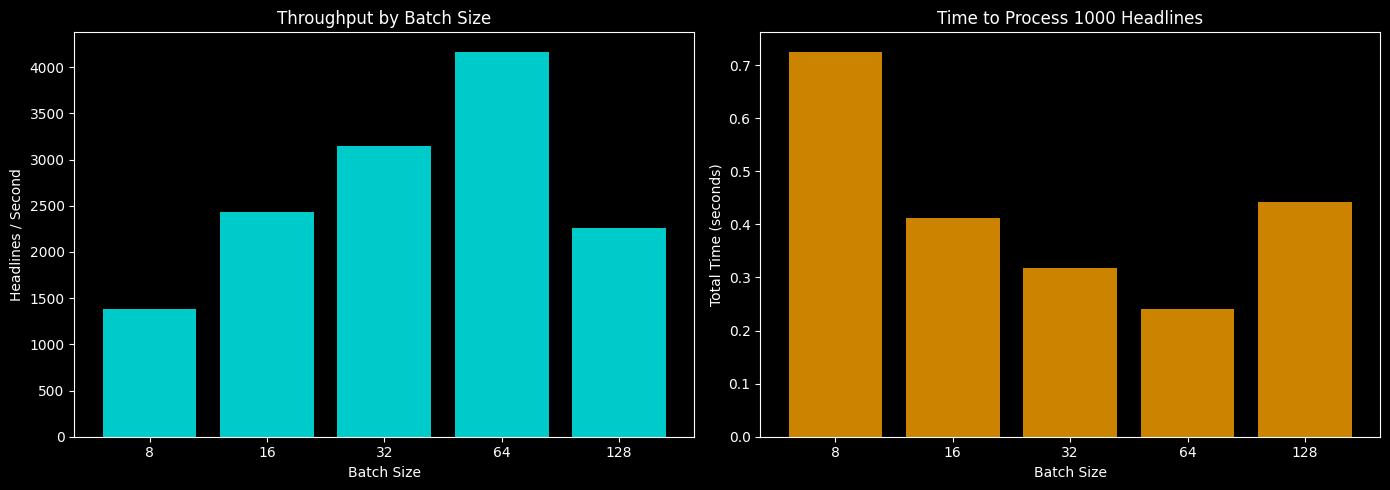

Larger batch sizes use GPU parallelism more efficiently.
For real-time use, accumulate headlines into mini-batches before processing.


In [20]:
# Visualize throughput by batch size
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

bs_list = list(results_benchmark.keys())
speeds = [results_benchmark[bs]['speed'] for bs in bs_list]
times = [results_benchmark[bs]['time'] for bs in bs_list]

ax1.bar(range(len(bs_list)), speeds, color='cyan', alpha=0.8)
ax1.set_xticks(range(len(bs_list)))
ax1.set_xticklabels([str(bs) for bs in bs_list])
ax1.set_xlabel('Batch Size')
ax1.set_ylabel('Headlines / Second')
ax1.set_title('Throughput by Batch Size')

ax2.bar(range(len(bs_list)), times, color='orange', alpha=0.8)
ax2.set_xticks(range(len(bs_list)))
ax2.set_xticklabels([str(bs) for bs in bs_list])
ax2.set_xlabel('Batch Size')
ax2.set_ylabel('Total Time (seconds)')
ax2.set_title(f'Time to Process {len(benchmark_headlines)} Headlines')

plt.tight_layout()
plt.show()

print("Larger batch sizes use GPU parallelism more efficiently.")
print("For real-time use, accumulate headlines into mini-batches before processing.")

---
## 9. Live Monitoring Architecture

Here's how to build a real-time sentiment monitoring system.
This section provides the architecture -- you'd run this as a separate Python script,
not in a notebook.

```
┌─────────────┐    ┌──────────────┐    ┌─────────────────┐    ┌──────────────┐
│  News Sources│    │  Headline    │    │  GPU Sentiment  │    │  Trading     │
│              │───>│  Queue       │───>│  Pipeline       │───>│  Signals     │
│  - RSS feeds │    │              │    │                 │    │              │
│  - NewsAPI   │    │  Batch every │    │  - FinBERT      │    │  - Per-stock │
│  - Twitter/X │    │  5 seconds   │    │  - Twitter-RoBERTa│  │    scores    │
│  - Reddit    │    │              │    │  - NER          │    │  - Alerts    │
│  - SEC EDGAR │    │              │    │                 │    │  - Dashboard │
└─────────────┘    └──────────────┘    └─────────────────┘    └──────────────┘
```

In [21]:
# Architecture blueprint: Real-time Sentiment Monitor
# Save this as a standalone script when ready to deploy

MONITOR_CODE = '''
#!/usr/bin/env python3
"""
Real-Time Financial Sentiment Monitor
Runs as a background service, continuously analyzing news.

Usage:
    python sentiment_monitor.py --watchlist NVDA,TSLA,AAPL --interval 30
"""

import time
import json
import threading
import queue
from datetime import datetime
from collections import defaultdict

import feedparser
import torch
from transformers import pipeline


class SentimentMonitor:
    def __init__(self, watchlist, batch_interval=5, alert_threshold=0.5):
        self.watchlist = watchlist
        self.batch_interval = batch_interval  # seconds between processing batches
        self.alert_threshold = alert_threshold
        self.headline_queue = queue.Queue()
        self.sentiment_history = defaultdict(list)  # ticker -> [(timestamp, score)]
        self.seen_headlines = set()  # dedup
        
        # Load models
        device = 0 if torch.cuda.is_available() else -1
        self.sentiment_model = pipeline(
            "sentiment-analysis", model="ProsusAI/finbert",
            device=device, truncation=True, max_length=512,
        )
    
    def fetch_loop(self, feeds, interval=30):
        """Continuously fetch headlines from RSS feeds."""
        while True:
            for name, url in feeds.items():
                try:
                    feed = feedparser.parse(url)
                    for entry in feed.entries[:20]:
                        title = entry.get("title", "")
                        if title and title not in self.seen_headlines:
                            self.seen_headlines.add(title)
                            self.headline_queue.put({
                                "title": title,
                                "source": name,
                                "timestamp": datetime.now().isoformat(),
                            })
                except Exception as e:
                    print(f"Feed error ({name}): {e}")
            time.sleep(interval)
    
    def process_loop(self):
        """Process queued headlines in batches on GPU."""
        while True:
            batch = []
            # Collect headlines for batch_interval seconds
            deadline = time.time() + self.batch_interval
            while time.time() < deadline:
                try:
                    item = self.headline_queue.get(timeout=0.5)
                    batch.append(item)
                except queue.Empty:
                    continue
            
            if not batch:
                continue
            
            # Batch sentiment analysis on GPU
            texts = [item["title"] for item in batch]
            results = self.sentiment_model(texts, batch_size=32)
            
            for item, result in zip(batch, results):
                score = self._normalize(result)
                tickers = self._extract_tickers(item["title"])
                
                for ticker in tickers:
                    self.sentiment_history[ticker].append(
                        (item["timestamp"], score)
                    )
                    
                    # Alert on strong sentiment
                    if abs(score) > self.alert_threshold:
                        direction = "BULLISH" if score > 0 else "BEARISH"
                        print(f"[ALERT] {direction} {ticker} ({score:+.2f}): {item['title'][:60]}")
    
    def _normalize(self, result):
        label = result["label"].lower()
        score = result["score"]
        if "positive" in label:
            return score
        elif "negative" in label:
            return -score
        return 0.0
    
    def _extract_tickers(self, text):
        # Simplified keyword matching (use the full version from notebook)
        found = []
        for ticker in self.watchlist:
            if ticker in text.upper():
                found.append(ticker)
        return found
    
    def get_current_sentiment(self, ticker, window_minutes=60):
        """Get average sentiment for a ticker over the last N minutes."""
        cutoff = datetime.now() - timedelta(minutes=window_minutes)
        recent = [
            score for ts, score in self.sentiment_history[ticker]
            if datetime.fromisoformat(ts) > cutoff
        ]
        if not recent:
            return 0.0, 0
        return sum(recent) / len(recent), len(recent)
    
    def run(self, feeds):
        """Start the monitor with fetch and process threads."""
        fetch_thread = threading.Thread(
            target=self.fetch_loop, args=(feeds, 30), daemon=True
        )
        process_thread = threading.Thread(
            target=self.process_loop, daemon=True
        )
        
        fetch_thread.start()
        process_thread.start()
        
        print("Sentiment monitor running. Press Ctrl+C to stop.")
        try:
            while True:
                time.sleep(60)
                # Print periodic summary
                print(f"\\n--- Sentiment Summary ({datetime.now().strftime('%H:%M')}) ---")
                for ticker in self.watchlist:
                    avg, count = self.get_current_sentiment(ticker)
                    if count > 0:
                        print(f"  {ticker}: {avg:+.3f} ({count} headlines in last hour)")
        except KeyboardInterrupt:
            print("Monitor stopped.")
'''

# Save the monitor script
with open('sentiment_monitor.py', 'w') as f:
    f.write(MONITOR_CODE)

print("Saved: sentiment_monitor.py")
print("\nTo run the live monitor:")
print("  python sentiment_monitor.py")
print("\nIt will continuously:")
print("  1. Fetch headlines from RSS feeds every 30 seconds")
print("  2. Batch-process them through FinBERT on GPU every 5 seconds")
print("  3. Extract tickers and aggregate sentiment per stock")
print("  4. Alert on strong sentiment signals (>0.5 or <-0.5)")
print("  5. Print hourly sentiment summaries")

Saved: sentiment_monitor.py

To run the live monitor:
  python sentiment_monitor.py

It will continuously:
  1. Fetch headlines from RSS feeds every 30 seconds
  2. Batch-process them through FinBERT on GPU every 5 seconds
  3. Extract tickers and aggregate sentiment per stock
  4. Alert on strong sentiment signals (>0.5 or <-0.5)
  5. Print hourly sentiment summaries


---
## 10. Advanced: Sentiment-Based Trading Signals

How to convert raw sentiment into actionable trading signals.

In [22]:
# Build a simple sentiment-based signal generator

class SentimentSignalGenerator:
    """
    Converts raw sentiment scores into trading signals.
    
    Signal types:
      +2 = Strong bullish (high confidence buy signal)
      +1 = Mild bullish (lean long)
       0 = Neutral (no signal)
      -1 = Mild bearish (lean short)
      -2 = Strong bearish (high confidence sell signal)
    """
    
    def __init__(self, strong_threshold=0.4, mild_threshold=0.15, 
                 min_headlines=3, agreement_threshold=0.3):
        self.strong_threshold = strong_threshold
        self.mild_threshold = mild_threshold
        self.min_headlines = min_headlines
        self.agreement_threshold = agreement_threshold
    
    def generate_signal(self, avg_sentiment, headline_count, sentiment_std):
        """
        Generate a trading signal from aggregated sentiment data.
        
        Parameters:
            avg_sentiment: Average ensemble score (-1 to +1)
            headline_count: Number of headlines analyzed
            sentiment_std: Standard deviation (model agreement)
        """
        # Not enough data
        if headline_count < self.min_headlines:
            return 0, "Insufficient data"
        
        # High disagreement between models = unreliable
        if sentiment_std > self.agreement_threshold:
            return 0, "Models disagree -- ambiguous"
        
        # Generate signal based on average sentiment
        if avg_sentiment > self.strong_threshold:
            return 2, f"STRONG BULLISH (sentiment: {avg_sentiment:+.3f})"
        elif avg_sentiment > self.mild_threshold:
            return 1, f"Mild bullish (sentiment: {avg_sentiment:+.3f})"
        elif avg_sentiment < -self.strong_threshold:
            return -2, f"STRONG BEARISH (sentiment: {avg_sentiment:+.3f})"
        elif avg_sentiment < -self.mild_threshold:
            return -1, f"Mild bearish (sentiment: {avg_sentiment:+.3f})"
        else:
            return 0, f"Neutral (sentiment: {avg_sentiment:+.3f})"

# Apply to our per-stock sentiment data
signal_gen = SentimentSignalGenerator()

print("=== SENTIMENT-BASED TRADING SIGNALS ===")
print(f"{'Ticker':<8} {'Headlines':>9} {'Avg Sent':>10} {'Std':>8} {'Signal':>8} {'Reasoning'}")
print("-" * 85)

if not ticker_sentiment.empty:
    for ticker, row in ticker_sentiment.iterrows():
        signal, reason = signal_gen.generate_signal(
            row['avg_sentiment'],
            row['headline_count'],
            row.get('sentiment_std', 0) if pd.notna(row.get('sentiment_std', 0)) else 0
        )
        signal_icon = {2: '++', 1: '+ ', 0: '  ', -1: ' -', -2: '--'}[signal]
        print(f"{ticker:<8} {int(row['headline_count']):>9} {row['avg_sentiment']:>+10.3f} "
              f"{row.get('sentiment_std', 0):>8.3f} {signal_icon:>8} {reason}")

print("\n--- Signal Interpretation ---")
print("++ Strong Bullish: Consider long positions with confirmation from technicals")
print("+  Mild Bullish:   Lean bullish, but wait for technical entry")
print("   Neutral:        No sentiment edge -- rely on technical analysis only")
print(" - Mild Bearish:   Lean bearish, or tighten stops on longs")
print("-- Strong Bearish: Consider short positions or avoid longs")
print("\nIMPORTANT: Sentiment is ONE input. Always combine with:")
print("  - Technical analysis (support/resistance, indicators)")
print("  - Volume confirmation")
print("  - Risk management (position sizing, stop losses)")

=== SENTIMENT-BASED TRADING SIGNALS ===
Ticker   Headlines   Avg Sent      Std   Signal Reasoning
-------------------------------------------------------------------------------------
MSFT             2     -0.063    0.090          Insufficient data
AMD              2     -0.172    0.968          Insufficient data
AMZN             2     -0.243    0.807          Insufficient data
NVDA             2     -0.337    0.734          Insufficient data
SPY              1     -0.828      nan          Insufficient data

--- Signal Interpretation ---
++ Strong Bullish: Consider long positions with confirmation from technicals
+  Mild Bullish:   Lean bullish, but wait for technical entry
   Neutral:        No sentiment edge -- rely on technical analysis only
 - Mild Bearish:   Lean bearish, or tighten stops on longs
-- Strong Bearish: Consider short positions or avoid longs

IMPORTANT: Sentiment is ONE input. Always combine with:
  - Technical analysis (support/resistance, indicators)
  - Volume co

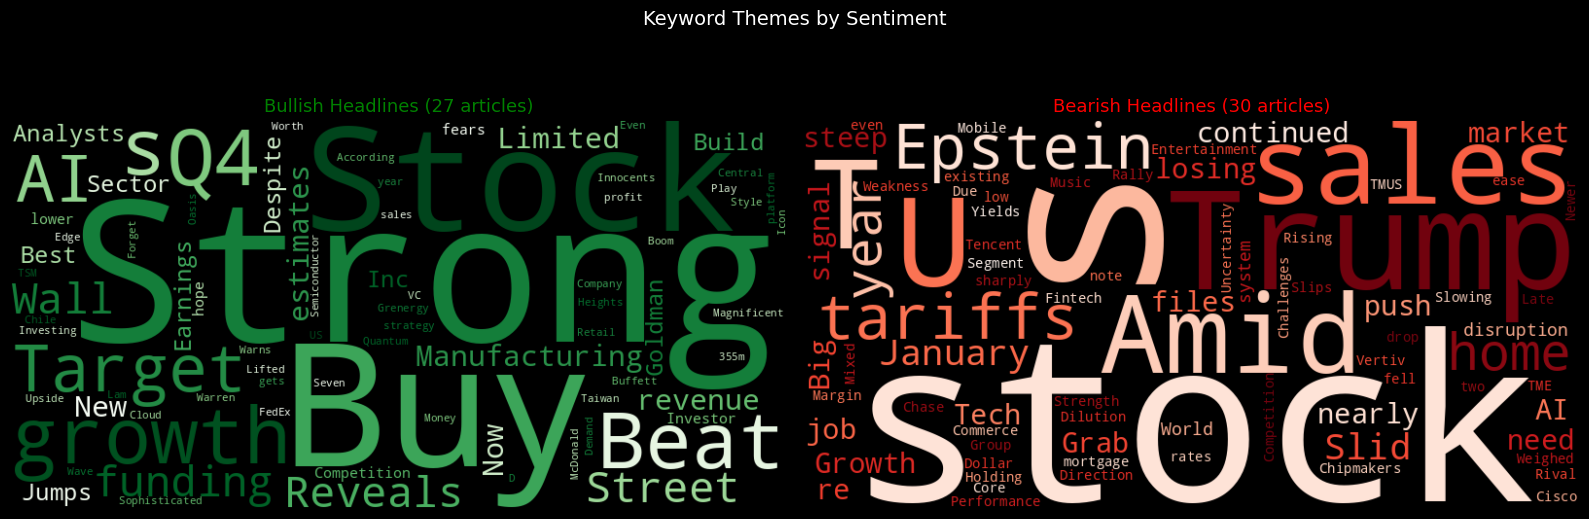

Word clouds reveal the dominant themes driving bullish vs bearish sentiment.
This helps you quickly understand WHAT is driving market mood.


In [23]:
# Word cloud of headlines by sentiment
from wordcloud import WordCloud

if len(results_df) > 5:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Bullish headlines word cloud
    bullish = results_df[results_df['ensemble_score'] > 0.1]['title']
    if len(bullish) > 0:
        bullish_text = ' '.join(bullish.tolist())
        wc_bull = WordCloud(
            width=800, height=400, background_color='black',
            colormap='Greens', max_words=80
        ).generate(bullish_text)
        axes[0].imshow(wc_bull, interpolation='bilinear')
        axes[0].set_title(f'Bullish Headlines ({len(bullish)} articles)', color='green', fontsize=13)
    axes[0].axis('off')

    # Bearish headlines word cloud
    bearish = results_df[results_df['ensemble_score'] < -0.1]['title']
    if len(bearish) > 0:
        bearish_text = ' '.join(bearish.tolist())
        wc_bear = WordCloud(
            width=800, height=400, background_color='black',
            colormap='Reds', max_words=80
        ).generate(bearish_text)
        axes[1].imshow(wc_bear, interpolation='bilinear')
        axes[1].set_title(f'Bearish Headlines ({len(bearish)} articles)', color='red', fontsize=13)
    axes[1].axis('off')

    plt.suptitle('Keyword Themes by Sentiment', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    print("Word clouds reveal the dominant themes driving bullish vs bearish sentiment.")
    print("This helps you quickly understand WHAT is driving market mood.")

---
## 11. Summary & Next Steps

### What We Built

| Component | Status |
|-----------|--------|
| RSS/Yahoo news fetching | Working |
| Multi-model sentiment (FinBERT + Twitter-RoBERTa + DistilRoBERTa) | Working |
| Entity/ticker extraction (keyword + NER) | Working |
| Per-stock sentiment aggregation | Working |
| Sentiment-price correlation framework | Working |
| GPU throughput benchmarking | Working |
| Trading signal generator | Working |
| Live monitoring script (sentiment_monitor.py) | Ready to deploy |

### Key Takeaways

1. **Your 4090 processes thousands of headlines per second** -- real-time analysis is trivially fast
2. **Multi-model ensembles are more robust** than any single model
3. **Model disagreement is itself a signal** -- ambiguity means uncertainty
4. **Sentiment is a complement to technical analysis**, not a replacement
5. **The architecture scales**: same pipeline works for 10 or 10,000 headlines

### Enhancement Ideas

- **Add social media sources**: Reddit (r/wallstreetbets, r/stocks), Twitter/X via API
- **Fine-tune FinBERT** on your own labeled data for better accuracy
- **Add earnings call analysis**: Transcribe and analyze with a local LLM
- **Sentiment decay modeling**: How long does a news event affect price?
- **Sector-level aggregation**: Aggregate sentiment across entire sectors
- **Contrarian signals**: Alert when sentiment is at extremes (potential reversals)

### Coming Up Next

**Notebook 03: Technical Strategy Backtesting** -- Build and test a complete trading strategy on historical data before risking real money.

In [24]:
# Clean up GPU memory
if torch.cuda.is_available():
    mem_before = torch.cuda.memory_allocated(0) / 1024**3
    del finbert, twitter_sentiment, distil_financial, ner_pipeline
    torch.cuda.empty_cache()
    mem_after = torch.cuda.memory_allocated(0) / 1024**3
    print(f"GPU memory freed: {mem_before:.1f} GB -> {mem_after:.1f} GB")

print("\nNotebook 02 complete. Your sentiment pipeline is ready for live use.")

GPU memory freed: 1.6 GB -> 1.2 GB

Notebook 02 complete. Your sentiment pipeline is ready for live use.


In [25]:
!nvidia-smi

Fri Feb 13 17:43:11 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.126.09             Driver Version: 580.126.09     CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090        Off |   00000000:04:00.0 Off |                  Off |
|  0%   34C    P8             14W /  450W |    1792MiB /  24564MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----